In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import tqdm
import numpy as np

In [9]:
video_path = R"D:\AFSSC\Documents\python学习\视频剪辑项目\手术原始视频.mp4"
template_path = R"templates\endoscope.png"
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Cannot open video.")
    
print(f"video:{video_path} opened.")
cap.set(cv2.CAP_PROP_POS_FRAMES, 114514)
testframe1  = cap.read()[1]
standard = testframe1
cap.set(cv2.CAP_PROP_POS_FRAMES, 444444)
testframe2  = cap.read()[1]

video:D:\AFSSC\Documents\python学习\视频剪辑项目\手术原始视频.mp4 opened.


In [10]:
tplt = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
tplt[np.where(tplt == 0 )] = 0
tplt[np.where(tplt == 50 )] = 0
tplt[np.where(tplt == 150 )] = 255
tplt[np.where(tplt == 250 )] = 0
tplt = cv2.resize(tplt,(1280,720))
tplt[np.where(tplt != 255 )] = 0

In [11]:
def masking(f,msk):
    # f = cv2.resize(f, (tplt.shape[1], tplt.shape[0]))
    msk = cv2.cvtColor(msk, cv2.COLOR_GRAY2BGR)
    f = cv2.bitwise_and(f, msk)
    return f

In [12]:

print(f"video:{video_path} opened.")
cap.set(cv2.CAP_PROP_POS_FRAMES, 114514)
testframe1  = cap.read()[1]
standard = testframe1
cap.set(cv2.CAP_PROP_POS_FRAMES, 444444)
testframe2  = cap.read()[1]

testframe1 = masking(testframe1,tplt)
testframe2 = masking(testframe2,tplt)

# 加载预训练的ResNet模型
model = models.resnet50(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])  # 去掉最后的全连接层
model.eval()

# 定义图像预处理
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 提取图像特征
testframe1 = cv2.cvtColor(testframe1, cv2.COLOR_BGR2RGB)  
testframe1 = Image.fromarray(testframe1)
testframe2 = cv2.cvtColor(testframe2, cv2.COLOR_BGR2RGB)
testframe2 = Image.fromarray(testframe2)

def extract_features(img):
    img= preprocess(img).unsqueeze(0)
    with torch.no_grad():
        features = model(img)
    return features.squeeze()

# 计算余弦相似度
def cosine_similarity(feature1, feature2):
    cos = nn.CosineSimilarity(dim=0)
    return cos(feature1, feature2).item()

# 示例图像路径
features1 = extract_features(testframe1)
features2 = extract_features(testframe2)

# 提取特征


# 计算相似度
similarity = cosine_similarity(features1, features2)

# 判断是否在同一阶段
threshold = 0.8  # 相似度阈值
print(f"相似度：{similarity}")

video:D:\AFSSC\Documents\python学习\视频剪辑项目\手术原始视频.mp4 opened.


d:\Anaconda\Anaconda3\envs\SurgeryAutoClip\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Anaconda3\envs\SurgeryAutoClip\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


相似度：0.7973247766494751


In [20]:
sim = []
base = 151451
off = 5000
cap.set(cv2.CAP_PROP_POS_FRAMES, base)
testframe1  = cap.read()[1]
testframe1 = masking(testframe1,tplt)
testframe1 = cv2.cvtColor(testframe1, cv2.COLOR_BGR2RGB)  
testframe1 = Image.fromarray(testframe1)
featurestd = extract_features(testframe1)
for i in tqdm.tqdm(range(base-off,base+off,50)):
    cap.set(cv2.CAP_PROP_POS_FRAMES, i)
    frame = cap.read()[1]
    if frame is None:
        break
    frame = masking(frame,tplt)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = Image.fromarray(frame)
    features = extract_features(frame)
    similarity = cosine_similarity(featurestd, features)
    sim.append(similarity)

100%|██████████| 200/200 [00:24<00:00,  8.02it/s]


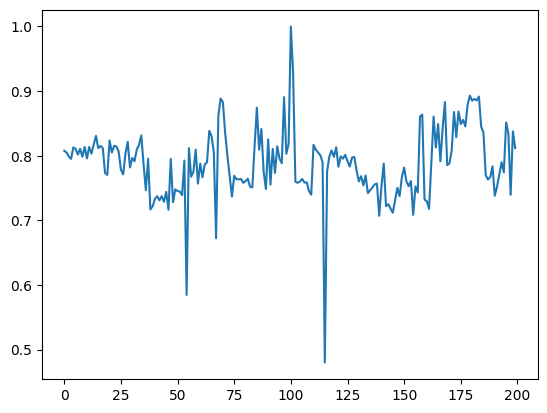

In [21]:
plt.plot(sim)

[5, 4, 3]